# GDMA - Assignment 4

Author: Julian Schelb (1069967)

In [1]:
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import pandas as pd

### Connection to the database instance

In [2]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "subatomic-shrank-Respond"))
session = driver.session()

### Question 1

Import the graph from the attached email-Eu-core.txt file. The file
represents a directed graph. 

Write the necessary Cypher and Python code to compute the significance
of each pattern. Use the configuration model and generate 5 random
networks. All subgraph matching queries must be executed in Neo4j. For
patterns (a) and (b) consider all matches (non-induced sugraphs) while
for pattern (c) consider induced subgraphs.

**Import Data:**

**Delete Existing Data:**

In [3]:
query = """
match (a) delete a
"""

with driver.session() as session:
    result = session.run(query)
    
    
query = """
match (a) -[r] -> () delete a, r
"""

with driver.session() as session:
    result = session.run(query)
    

In [4]:
query = """
LOAD CSV FROM 'file:///email-Eu-core.txt' AS row FIELDTERMINATOR ' '
WITH row[0] as sourceId, row[1] as targetId
MERGE (s:Node {id: sourceId})
MERGE (t:Node {id: targetId})
MERGE (s)-[:RELATED_TO]->(t)   
RETURN s, t
"""

with driver.session() as session:
    result = session.run(query)

***

#### Patterns:

**Assumption:** Nodes can be part of the pattern multiple times. For example in the case of an edge pointing back to the original source node. 

**Pattern a:**

In [5]:
pattern_a = """
MATCH (a:Node)-[r1:RELATED_TO]->(b:Node)-[r2:RELATED_TO]->(c:Node)
MATCH (a)-[r3:RELATED_TO]->(c) 
WHERE a <> b AND a <> c AND b <> c
RETURN count(*) as count
"""

dtf_data = pd.DataFrame([dict(_) for _ in session.run(pattern_a)])
dtf_data

,count
0,373386


svg image

\* Neo4j displays more edges than necessary. 

**Pattern b:**

In [6]:
pattern_b = """
MATCH (a:Node)-[r]->(b:Node)-[r2]->(d:Node)
MATCH (a)-[r3]->(c:Node)-[r4]->(d)
WHERE 
a <> b and a <> c and a <> d AND
b <> c and b <> d AND
d <> c
RETURN count(*) as count
"""

dtf_data = pd.DataFrame([dict(_) for _ in session.run(pattern_b)])
dtf_data

,count
0,17340998


svg image

\* Neo4j displays more edges than necessary. 

**Pattern c:**

In [7]:
pattern_c = """
MATCH (a:Node)
MATCH (a)-[r1]->(b:Node)
MATCH (a)-[r2]->(c:Node)
MATCH (a)-[r3]->(d:Node)
WITH a, b, c, d, r1, r2, r3
WHERE 

// No inward facing edges
a <> b AND a <> c AND a <> d AND
b <> c AND b <> d AND
d <> c

// No further edges between nodes
AND NOT EXISTS ((a)<--(b))
AND NOT EXISTS ((a)<--(c))
AND NOT EXISTS ((b)<--(d))

// No further edges between nodes
AND NOT EXISTS ((b)--(c))
AND NOT EXISTS ((c)--(d))
AND NOT EXISTS ((b)--(d))

// Self Links
AND NOT EXISTS ((a)--(a))
AND NOT EXISTS ((b)--(b))
AND NOT EXISTS ((c)--(c))
AND NOT EXISTS ((d)--(d))

//RETURN  a,b, c, d, r1, r2, r3 
RETURN COUNT(*) as count
LIMIT 1
"""

dtf_data = pd.DataFrame([dict(_) for _ in session.run(pattern_c)])
dtf_data

,count
0,5886


svg image

\* Neo4j displays more edges than necessary. 

***

#### Create Random Graphs:

* https://neo4j.com/labs/apoc/4.1/overview/apoc.node/apoc.node.degree/
* https://neo4j.com/labs/apoc/4.2/overview/apoc.generate/apoc.generate.simple/

Function for determining degree distribution of original graph:

In [8]:
def getDegreeDist(driver, database = "neo4j"):
    """Determining degree distribution of a given graph."""

    query = """
    MATCH (n:Node)
    RETURN collect(apoc.node.degree(n)) AS degree_dist
    """

    degree_dist = []
    with driver.session(database = database) as session:
        result = session.run(query)
        degree_dist = result.single().value()
    
    return degree_dist


In [9]:
degree_dist = getDegreeDist(driver)
degree_dist[:5]

[72, 160, 279, 61, 75]

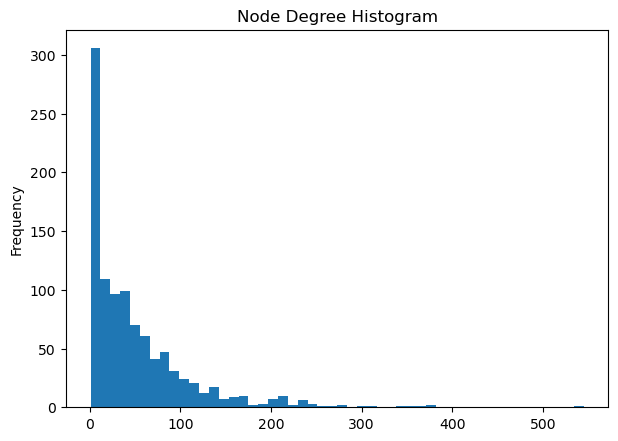

In [10]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Degree Distribution as Histogram
plt.hist(degree_dist, bins=50)
plt.gca().set(title='Node Degree Histogram', ylabel='Frequency');

Function for generate Random Graph:

In [11]:
def genRandomGraph(driver, database_name = "random", degree_dist = [2,2,2,2]):
    """Generate a random graph based on a given degree distribution."""
    
    #### Drop existing database if exists
    query = "DROP DATABASE $database_name IF EXISTS"
    with driver.session() as session:
        result = session.run(query, database_name = database_name)

    #### Create new database
    query = "CREATE DATABASE $database_name IF NOT EXISTS"
    with driver.session() as session:
        result = session.run(query, database_name = database_name)

    #### Generate random graph    
    query = "CALL apoc.generate.simple($degree_dist, \"Node\", \"RELATED_TO\")"
    with driver.session(database = database_name) as session:
        result = session.run(query, degree_dist = degree_dist)
    

In [12]:
genRandomGraph(driver, database_name = "random", degree_dist = degree_dist)
degree_dist = getDegreeDist(driver,  database = "random")

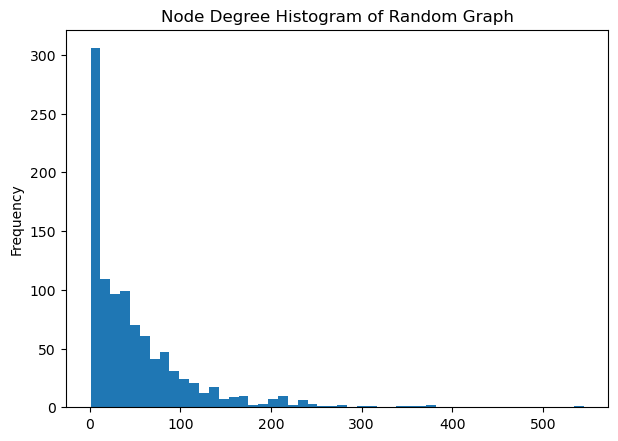

In [13]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Degree Distribution as Histogram
plt.hist(degree_dist, bins=50)
plt.gca().set(title='Node Degree Histogram of Random Graph', ylabel='Frequency');

***

#### Calculate Significance:

In [14]:
from statistics import mean, pstdev

Function for calculating significance of a given pattern.

In [24]:
def calcPatternSignificance(driver, pattern, database_name = "neo4j", database_name_random = "random", random_graphs = 5):

    #################### Count in Real Graph ####################

    N_real = None
    with driver.session() as session:
        result = session.run(pattern)
        N_real = result.single()["count"]

    print("Count in real Graph:", N_real)

    #################### Count in Random Graphs ####################

    # Get degree distribution and gen random graph
    degree_dist = getDegreeDist(driver,  database = database_name)

    # Count in n random generated graphs
    N_rand = []
    for i in range(0,random_graphs):
        genRandomGraph(driver, database_name = database_name_random, degree_dist = degree_dist)
        n_rand = None
        with driver.session(database = database_name_random) as session:
            result = session.run(pattern)
            n_rand = result.single()["count"]
            N_rand.append(n_rand)
            print(f"Count in random Graph {i}: {n_rand}")

    #################### Significance ####################

    N_rand_mean = mean(N_rand)
    N_rand_stdev = pstdev(N_rand)
    Z = (N_real - N_rand_mean) / N_rand_stdev
    
    #print("Counts in random Graph:", N_rand)
    print("Mean:", round(N_rand_mean, 2))
    print("Stdev:", round(N_rand_stdev, 2))
    print("Signficance", round(Z, 2))

    return Z

**Significance Pattern a:**

In [16]:
Z_a = calcPatternSignificance(driver, pattern_a)

Count in real Graph: 373386
Count in random Graph 0: 272185
Count in random Graph 1: 272704
Count in random Graph 2: 273072
Count in random Graph 3: 271389
Count in random Graph 4: 273272
Mean: 272524.4
Stdev: 677.55
Signficance 148.86


**Significance Pattern b:**

In [17]:
Z_b = calcPatternSignificance(driver, pattern_b)

Count in real Graph: 17340998
Count in random Graph 0: 15312454
Count in random Graph 1: 15340162
Count in random Graph 2: 15360082
Count in random Graph 3: 15343278
Count in random Graph 4: 15400606
Mean: 15351316.4
Stdev: 29002.15
Signficance 68.6


**Significance Pattern c:**

In [25]:
Z_c = calcPatternSignificance(driver, pattern_c)

Count in real Graph: 5886


StopIteration: 

***

### Question 2

Import the graph from the file karate.csv. Use the Louvain algorithm
to split the input graph into communities. You can find the description of
the user-defined procedure for the Louvain algorithm and other community
detection algorithms in the following link:

https://neo4j.com/docs/graph-data-science/current/algorithms/community/

Consider only the final community structure (disregard any intermediate communities). Then, print for each community (identified by the
communityId yielded by the user-defined procedure) the list of its border
nodes (identified by their nid given in the input file).

In [19]:
database_name = "karate"

**Import Data:**

In [20]:
#### Drop existing database if exists
query = "DROP DATABASE $database_name IF EXISTS"
with driver.session() as session:
    result = session.run(query, database_name = database_name)

#### Create new database
query = "CREATE DATABASE $database_name IF NOT EXISTS"
with driver.session() as session:
    result = session.run(query, database_name = database_name)
    
#### Import data

query = """
LOAD CSV FROM 'file:///karate.csv' AS row FIELDTERMINATOR ';'
WITH row[0] as sourceId, row[1] as targetId
MERGE (s:Node {id: sourceId})
MERGE (t:Node {id: targetId})
MERGE (s)-[:RELATED_TO]->(t)   
RETURN s, t
"""

with driver.session(database = database_name) as session:
    result = session.run(query)

**Determine Communities:**

**Assumption:** Community detection should be applied to the directed graph.

In [21]:
#### Drop existing graph projection if exists
query = """
CALL gds.graph.drop('karateCommunity', false) 
"""

with driver.session(database = database_name) as session:
    result = session.run(query)

#### Create new graph projection
query = """
//CALL gds.graph.project('karateCommunity', 'Node', {RELATED_TO: { orientation: 'UNDIRECTED'}})
CALL gds.graph.project('karateCommunity', 'Node', 'RELATED_TO')
"""

with driver.session(database = database_name) as session:
    result = session.run(query)

#### Determine communities
query = """
CALL gds.louvain.write('karateCommunity', { writeProperty: 'community' })
YIELD communityCount, modularity, modularities
"""

with driver.session(database = database_name) as session:
    result = session.run(query)
    print(f"Community Count {result.single()['communityCount']}")

Community Count 5


**Border Nodes per Community:**

In [22]:
query = """
MATCH (n:Node)
MATCH (n)-[r:RELATED_TO]-(m:Node)
WHERE n.community <> m.community
WITH n.community as community, n.id as nodeId
RETURN DISTINCT community, collect(DISTINCT nodeId) as border_nodes
"""

session = driver.session(database = database_name)
dtf_data = pd.DataFrame([dict(_) for _ in session.run(query)])
dtf_data.head()

,community,border_nodes
0,27,[1]
1,31,"[2, 4, 8, 13, 18]"
2,33,"[3, 9, 31, 32, 14, 20]"
3,28,[12]
4,32,[22]
